In [1]:
# ✅ Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (classification_report,
                             confusion_matrix,
                             roc_auc_score,
                             accuracy_score)

from sklearn.model_selection import RandomizedSearchCV

import joblib

In [2]:
# Step 1: Load Preprocessed Data
X_train = pd.read_csv("X_train_resampled.csv")
y_train = pd.read_csv("y_train_resampled.csv").squeeze()
X_test = pd.read_csv("X_test.csv")
y_test = pd.read_csv("y_test.csv").squeeze()

print("Train Shape:", X_train.shape)
print("Test Shape:", X_test.shape)

Train Shape: (452873, 30)
Test Shape: (56746, 30)


In [6]:
# Step 2: Define Baseline Models
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Support Vector Machine": CalibratedClassifierCV(
        estimator=LinearSVC(random_state=42),
        method='sigmoid',  # for probability calibration
        cv=3
    )
}

results = {}

In [7]:
# Step 3: Train & Evaluate Baseline Models
for name,model in models.items():
    print(f"\n🔹 Training {name}...")
    model.fit(X_train,y_train)

    y_pred=model.predict(X_test)
    y_prob=model.predict_proba(X_test)[:,1] if hasattr(model,"predict_proba") else None

    acc=accuracy_score(y_test,y_pred)
    roc_auc=roc_auc_score(y_test,y_prob) if y_prob is not None else None

    print("Accuracy:", acc)
    if roc_auc is not None:
        print("ROC-AUC:", roc_auc)
    
    report = classification_report(y_test, y_pred, target_names=['Not Fraud', 'Fraud'])
    print("\nClassification Report:\n", report)
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    
    results[name] = {"accuracy": acc, "roc_auc": roc_auc}

results_df = pd.DataFrame(results).T
print("\n📊 Baseline Model Comparison:\n", results_df)


🔹 Training Logistic Regression...
Accuracy: 0.9728791456666549
ROC-AUC: 0.9620937615260193

Classification Report:
               precision    recall  f1-score   support

   Not Fraud       1.00      0.97      0.99     56651
       Fraud       0.05      0.87      0.10        95

    accuracy                           0.97     56746
   macro avg       0.53      0.92      0.54     56746
weighted avg       1.00      0.97      0.98     56746

Confusion Matrix:
 [[55124  1527]
 [   12    83]]

🔹 Training Decision Tree...
Accuracy: 0.9977267120149438
ROC-AUC: 0.8675031518001727

Classification Report:
               precision    recall  f1-score   support

   Not Fraud       1.00      1.00      1.00     56651
       Fraud       0.40      0.74      0.52        95

    accuracy                           1.00     56746
   macro avg       0.70      0.87      0.76     56746
weighted avg       1.00      1.00      1.00     56746

Confusion Matrix:
 [[56547   104]
 [   25    70]]

🔹 Training Random

In [8]:
# Step 4: Hyperparameter Tuning (Top Models)

# ---- Random Forest Tuning ----
rf_params = {
    "n_estimators": [100, 200],        
    "max_depth": [10, 20, None],       
    "min_samples_split": [2, 5],       
    "min_samples_leaf": [1, 2]         
}

rf_grid = RandomizedSearchCV(
    RandomForestClassifier(random_state=42, class_weight="balanced"),
    rf_params,
    cv=3,
    scoring="roc_auc",
    n_jobs=-1,
    verbose=2,
    n_iter=10  
)

rf_grid.fit(X_train, y_train)
print("\n✅ Best RF Params:", rf_grid.best_params_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END max_depth=20, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=11.6min
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=11.8min
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=12.0min
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=12.0min
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time= 6.7min
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time= 6.9min
[CV] END max_depth=20, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=15.1min
[CV] END max_depth=20, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=15.4min
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time= 8.6min
[CV] END max_depth

In [42]:
# Step 5: Evaluate Tuned Models
tuned_models = {
    "Random Forest (Tuned)": rf_grid.best_estimator_,
}

fraud_threshold = 0.5

for name, model in tuned_models.items():
    print(f"\n🔹 Evaluating {name}...")
    y_prob = model.predict_proba(X_test)[:, 1]
    
    # Apply threshold to predict Fraud
    y_pred = (y_prob > fraud_threshold).astype(int)
    
    acc = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_prob)
    
    print("Accuracy:", acc)
    print("ROC-AUC:", roc_auc)
    
    report = classification_report(y_test, y_pred, target_names=['Not Fraud', 'Fraud'])
    print("\nClassification Report:\n", report)
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    
    results["Random Forest"] = {"accuracy": acc, "roc_auc": roc_auc}

print(f"\n✅ Threshold for Fraud class set at {fraud_threshold}")


🔹 Evaluating Random Forest (Tuned)...
Accuracy: 0.9993832164381631
ROC-AUC: 0.9789631622612691

Classification Report:
               precision    recall  f1-score   support

   Not Fraud       1.00      1.00      1.00     56651
       Fraud       0.86      0.76      0.80        95

    accuracy                           1.00     56746
   macro avg       0.93      0.88      0.90     56746
weighted avg       1.00      1.00      1.00     56746

Confusion Matrix:
 [[56639    12]
 [   23    72]]

✅ Threshold for Fraud class set at 0.5



📊 Final Model Comparison:
                         accuracy   roc_auc
Logistic Regression     0.972879  0.962094
Decision Tree           0.997727  0.867503
Random Forest           0.999383  0.978963
K-Nearest Neighbors     0.997744  0.920361
Support Vector Machine  0.973478  0.965080


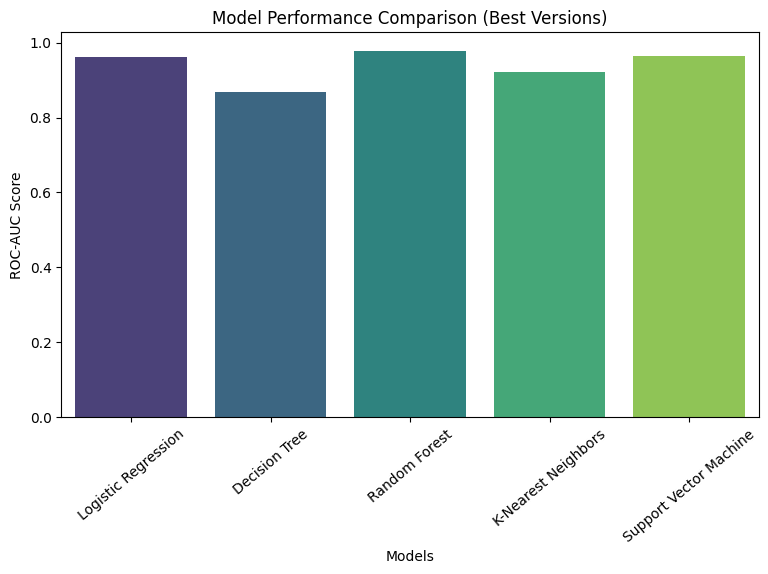

In [43]:
# Step 6: Final Comparison
results_df = pd.DataFrame(results).T
print("\n📊 Final Model Comparison:\n", results_df)

plt.figure(figsize=(9,5))
sns.barplot(x=results_df.index,y=results_df['roc_auc'],palette="viridis",hue=results_df.index)
plt.xticks(rotation=40)
plt.xlabel("Models")
plt.ylabel("ROC-AUC Score")
plt.title("Model Performance Comparison (Best Versions)")
plt.show()

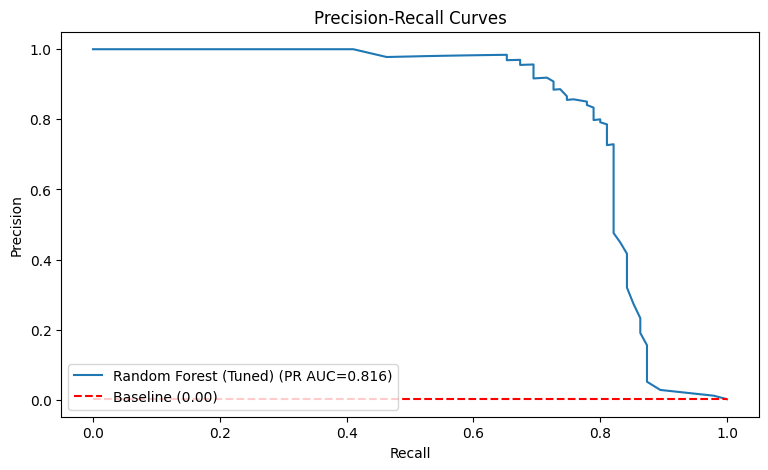

In [44]:
# Precision-Recall Curve (PR Curve)
from sklearn.metrics import precision_recall_curve, auc

plt.figure(figsize=(9,5))
for name, model in tuned_models.items():
    y_prob = model.predict_proba(X_test)[:, 1]  # probability of fraud
    precision, recall, _ = precision_recall_curve(y_test, y_prob)
    pr_auc = auc(recall, precision)
    plt.plot(recall, precision, label=f"{name} (PR AUC={pr_auc:.3f})")

# Baseline: random guessing = positive class ratio
baseline = y_test.mean()
plt.hlines(y=baseline, xmin=0, xmax=1, color="red", linestyle="--", label=f"Baseline ({baseline:.2f})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curves")
plt.legend()
plt.show()

In [47]:
# Step 7: Save Best Model
best_model_name=results_df['roc_auc'].idxmax()
best_model=(
    tuned_models[best_model_name] 
    if best_model_name in tuned_models 
    else models[best_model_name]
)

feature_columns = X_train.columns.tolist()  # This includes Time, Amount, V1–V28
joblib.dump({
    "model": best_model,
    "threshold": fraud_threshold,
    "feature_names": feature_columns
}, "fraudshield_best_model.pkl")

print(f"\n✅ Best Model: {best_model_name} saved as 'fraudshield_best_model.pkl'")


✅ Best Model: Random Forest saved as 'fraudshield_best_model.pkl'
